# Preprocess SMB and KI levels into chunks

- Project: PCGML, VAE
- Date: 2019/08/14

In [136]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt

In [137]:
import sys
sys.path.append('../modules')

## Encoding scheme

In [138]:
from vglc_with_path_encodings import Encoding, array_from_json, array_to_image

## Hyper-parameters

Run this cell before running the "Preprocess pipeline" to get chunks from **all SMB levels**:

In [143]:
txt_folder_path = '../data/vglc-smb-with-path-levels'
game = 'SMB'
json_name = '../data/smbWithPath-allLevels-chunks-int'

Run this cell before running the "Preprocess pipeline" to get chunks from **all KI levels**:

In [139]:
txt_folder_path = '../data/vglc-ki-with-path-levels'
game = 'KI'
json_name = '../data/kiWithPath-allLevels-chunks-int'

## Preprocess pipeline

In [144]:
chunks_by_level = []
txt_fnames = sorted([fname for fname in os.listdir(txt_folder_path) if fname.split('.')[-1] == 'txt'])

for fname in txt_fnames:  # process one file at a time
    
    # 1: load a txt file into a string
    with open(os.path.join(txt_folder_path, fname)) as f:
        string = f.read()
        
    # 2: split the string into lines at newline characters
    rows = string.split('\n')  

    if game == 'SMB' or game == 'KI':
        rows = rows[:-1]  
        # for both SMBA and KIA levels, last row is an empty string
        # if this step is not done, it would prevent the arrays of characters to be converted into np array

    # 3: split each line into separate characters
    rows = [list(row) for row in rows]  

    # remove invalid characters
    rows = np.array(rows)
    for invalid_char in ['B', 'b']:
        rows[rows == invalid_char] = '-'
        
    # re-encode background tiles for KI levels
    if game == 'KI':
        rows[rows == '-'] = '*'

    # step 4: encode characters with integers using a specificed encoding scheme
    if game == 'SMB':
        level_int = [[Encoding.char2int_smb[item] for item in row] for row in rows]  
    elif game == 'KI':
        level_int = [[Encoding.char2int_ki[item] for item in row] for row in rows]
        
    # step 5: move a 16-by-16 window over the level, obtain chunks
    
    level_int = np.array(level_int)
    
    if game == 'SMB':
#         level_int = np.vstack([np.zeros((2, level_int.shape[1]))+2, level_int])
        array_width = level_int.shape[1] + 1
        chunks_int = [level_int[:,left:left+16] for left in range(0, array_width-16)]
        print(np.array(chunks_int).shape)
        chunks_by_level.extend(chunks_int)

    elif game == 'KI':
        array_height = level_int.shape[0] + 1
        chunks_int = [level_int[top:top+16,:] for top in range(0, array_height-16)]
        print(np.array(chunks_int).shape)
        chunks_by_level.extend(chunks_int)
            
chunks_int = np.array(chunks_by_level, dtype='int')
print(np.unique(chunks_int))

# no onehot encoding, because saving onehot encoded chunks makes the resulting json file too big
# onehot = np.eye(17)
# chunks_onehot = onehot[chunks_int]
# chunks_onehot = np.rollaxis(chunks_onehot, 3, 1)

(187, 16, 16)
(143, 16, 16)
(135, 16, 16)
(182, 16, 16)
(182, 16, 16)
(134, 16, 16)
(207, 16, 16)
(172, 16, 16)
(183, 16, 16)
(135, 16, 16)
(169, 16, 16)
(200, 16, 16)
(150, 16, 16)
(161, 16, 16)
(358, 16, 16)
[ 0  1  2  3  4  5  6  7  8  9 10 11]


## Check array shape and save chunks as json

In [141]:
print(chunks_int.shape)

(1297, 16, 16)


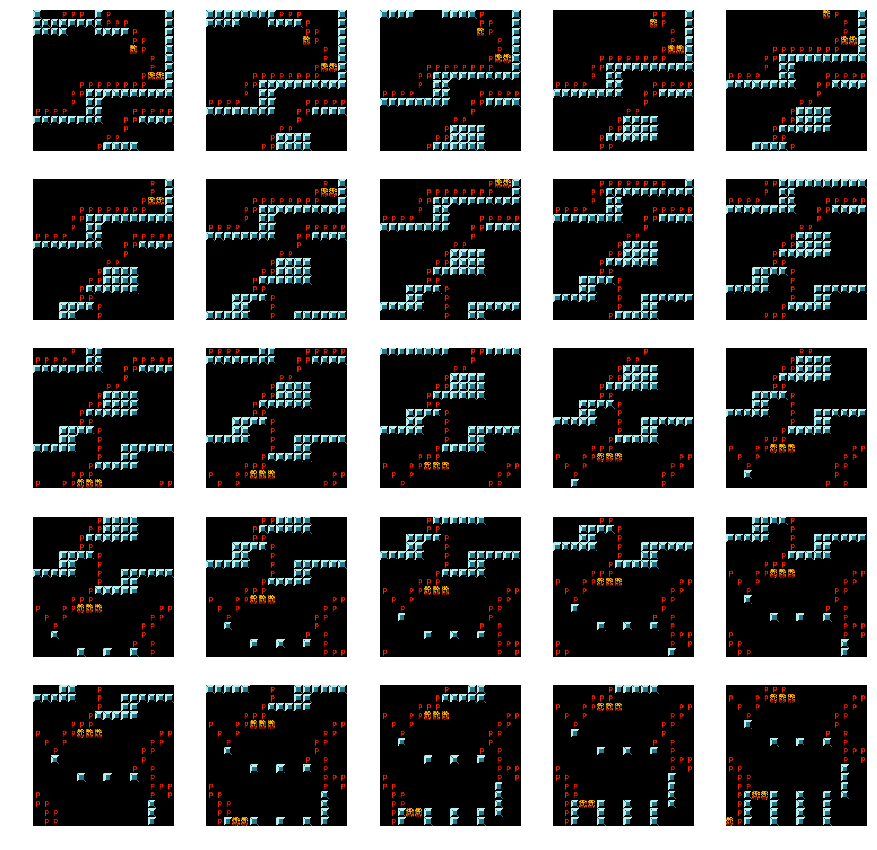

In [142]:
fig = plt.figure(figsize=(15, 15))
nrows, ncols = 5, 5
start = 10
for i in range(nrows * ncols):
    ax = fig.add_subplot(nrows, ncols, i+1)
    ax.imshow(array_to_image([chunks_int[i+start]], game=game.lower()))
    ax.axis('off')

In [135]:
with open(f'{json_name}.json', 'w+') as f:
    json.dump(chunks_int.tolist(), f)

## Generate labels for SMB chunks (with pipe or not)

In [46]:
labels = []
for chunk in chunks_int:
    if (6 in chunk) or (7 in chunk) or (8 in chunk) or (9 in chunk):
        labels.append(1)
    else:
        labels.append(0)
labels = np.array(labels)

In [47]:
with open(f'smb_labels_pipe.json', 'w+') as f:
    json.dump(labels.tolist(), f)